# Pulsar Folding and Searching 
#### **By Peter Ma**

Pulsar searching is a very compute intensive task. Searching for repeating signals within noisy data is difficult because pulses tend to have a low signal to noise ratio. Our goal is to process, clean, identify potential periods and fold the pulses to increase the SNR. This notebook illustrates the basic algorithms used for searching and detecting pulses within radio spectrograms. 

Keep in mind, there are faster algorithms that are used in state-of-the-art pulsar search pipelines [ex. Tree dedispersion]. This notebook implements the simplest pulsar searching technique. 

First, we start with downloading the data and `BLIMPY` which is an I/O tool developed to interface with the radio data.

**Note**: Run this notbook in COLAB as some operations would be fairly resource intensive. For example downloading and loading multiple GB files into RAM. This notebook has not been optimized.

In [9]:
!pip install blimpy
# Pulsar data
!wget http://blpd13.ssl.berkeley.edu/borisov/AGBT19B_999_124/spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58837_86186_PSR_B0355+54_0013.gpuspec.8.0001.fil
# For more info on pulsar searches check out this deck
# http://ipta.phys.wvu.edu/files/student-week-2017/IPTA2017_KuoLiu_pulsartiming.pdf

--2020-06-01 02:06:21--  http://blpd13.ssl.berkeley.edu/borisov/AGBT19B_999_124/spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58837_86186_PSR_B0355+54_0013.gpuspec.8.0001.fil
Resolving blpd13.ssl.berkeley.edu (blpd13.ssl.berkeley.edu)... 208.68.240.55
Connecting to blpd13.ssl.berkeley.edu (blpd13.ssl.berkeley.edu)|208.68.240.55|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8776581466 (8.2G) [application/octet-stream]
Saving to: ‘spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58837_86186_PSR_B0355+54_0013.gpuspec.8.0001.fil.1’

spliced_blc40414243 100%[===================>]   8.17G  15.4MB/s    in 8m 49s  

2020-06-01 02:15:11 (15.8 MB/s) - ‘spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58837_86186_PSR_B0355+54_0013.gpuspec.8.0001.fil.1’ saved [8776581466/8776581466]



# Loading Data

First, we load the data. NOTE targets with the starting name of PSR are radio scans of known pulsars `PSR_B0355+54_0013`. On the other hand, files starting with HIP `HIP65960` are cataloged targets that shouldn't have pulsar characteristics. If you wish to learn more about the data check out https://ui.adsabs.harvard.edu/abs/2019PASP..131l4505L/abstract

The header information gives vital information regarding the observational setup of the telescope. For example, the coarse channel width or the observation time and duration etc. 

blimpy.io.base_reader WARNING  Selection size of 8.17 GB, exceeding our size limit 1.00 GB. Instance created, header loaded, but data not loaded, please try another (t,v) selection.

--- File Info ---
     rawdatafile :                                 
     source_name :                     PSR_B0355+54
      machine_id :                               10
    telescope_id :                                6
         src_raj :                      3:58:53.496
         src_dej :                      54:13:14.88
        az_start :                              0.0
        za_start :                              0.0
       data_type :                                1
            fch1 :            11251.28173828125 MHz
            foff :                -0.3662109375 MHz
          nchans :                            10240
          nbeams :                                0
           ibeam :                                0
           nbits :                                8
   tstart (ISOT) : 

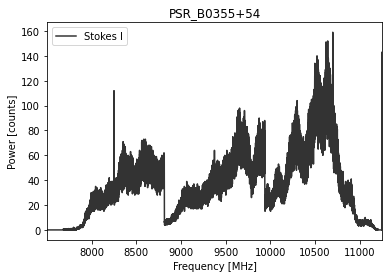

In [23]:
from blimpy import Waterfall
import pylab as plt
import numpy as np
import math
from scipy import stats, interpolate
from copy import deepcopy
%matplotlib inline


header = Waterfall('/content/spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58837_86186_PSR_B0355+54_0013.gpuspec.8.0001.fil',load_data=True)
header.info()

obs = Waterfall('/content/spliced_blc40414243444546o7o0515253545556o7o061626364656667_guppi_58837_86186_PSR_B0355+54_0013.gpuspec.8.0001.fil', 
               t_start=0,t_stop= 80000,max_load=10)
# Loads data into numpy array 
data = obs.data
data.shape
coarse_channel_width = np.int(np.round(187.5/64/abs(obs.header['foff'])))
# Here we plot the integrated signal over time.
obs.plot_spectrum()

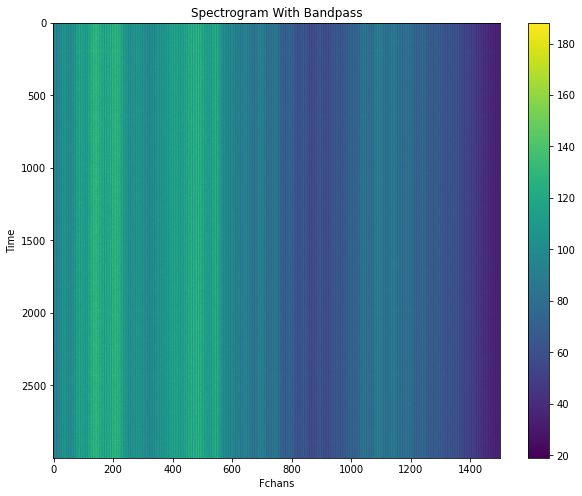

In [24]:
fig = plt.figure(figsize=(10,8))
plt.title('Spectrogram With Bandpass')
plt.xlabel("Fchans")
plt.ylabel("Time")
plt.imshow(data[:3000,0,1500:3000], aspect='auto')
plt.colorbar()

# Band Pass Removal
The goal of this process is to clean the data of its artifacts created by combining multiple bands.  We get our data products by putting that array through a bunch of bandpass filters. They’re called band-pass because they only allow signals in a particular frequency range, called a band, to pass-through. When the products are assembled we see these dips in the spectrogram. In other words - they aren't real signals.

To remove the bandpass, we use spline lines to fit each channel to obtain a model of the bandpass of that channel. By using splines, we can fit the bandpass without fitting the more significant signals. 

If you want more details on this check out https://github.com/FX196/SETI-Energy-Detection for a more detailed explanation. 

![image.png](https://github.com/PetchMa/Pulsar_Folding/blob/master/assets/image%20(6).png?raw=true)

Fitting Spline


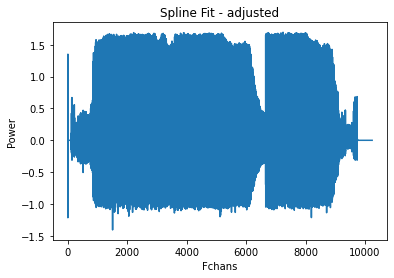

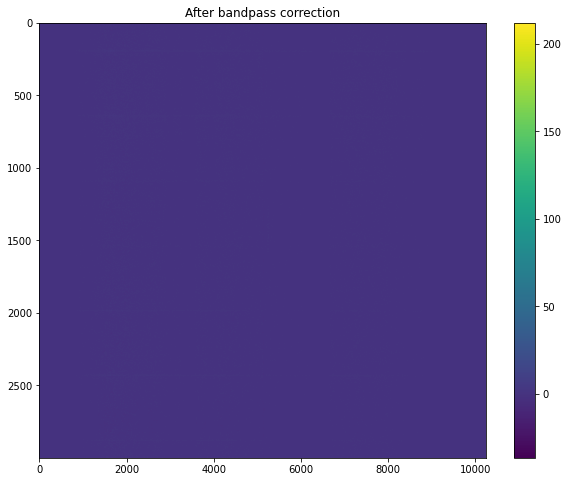

In [25]:
average_power = np.zeros((data.shape[2]))
shifted_power = np.zeros((int(data.shape[2]/8)))
x=[]
spl_order = 2
print("Fitting Spline")
data_adjust = np.zeros(data.shape)
average_power = data.mean(axis=0)
#  Note the value 8 is the COARSE CHANNEL WIDTH
#  We adjust each coarse channel to correct the bandpass artifacts
for i in range(0, data.shape[2], 8):
    average_channel = average_power[0,i:i+8]
    x = np.arange(0,coarse_channel_width,1)
    knots = np.arange(0, coarse_channel_width, coarse_channel_width//spl_order+1)

    tck = interpolate.splrep(x, average_channel, s=knots[1:])
    xnew = np.arange(0, coarse_channel_width,1)
    ynew = interpolate.splev(xnew, tck, der=0)
    data_adjust[:,0,i:i+8]  = data[:,0,i:i+8] - ynew

plt.figure()
plt.plot( data_adjust.mean(axis=0)[0,:])
plt.title('Spline Fit - adjusted')
plt.xlabel("Fchans")
plt.ylabel("Power")
fig = plt.figure(figsize=(10,8))
plt.title('After bandpass correction')
plt.imshow(data_adjust[:3000,0,:], aspect='auto')
plt.colorbar()

# Dedispersion
When pulsar pulses reach Earth they actually reach the observer at different times because the radiation travels through an interstellar medium causing dispersion of the pulses. These appear as a swooping curve instead of straight horizontal lines [plane waves]. If we are going to fold the pulses to increase SNR then we're making the assumption that the pulses arrive at the same time. Thus we need to correct the dispersion by shifting each channel down a certain time delay relative to its frequency channel. Computationally we index a column of the spectrogram in frequency and split it between a time delay and original data and swap the positions.

However, the problem is, we don't know the dispersion measure `DM` of the signal. The `DM` is the path integral of the signal through the interstellar medium with an electron density measure of.
$$DM =\int_0^d n_e dl$$ 

What we do is we brute force the `DM` by executing multiple trials `DM`s and we take the highest SNR created by the dedispersion with the given trial `DM`.

![alt text](https://astronomy.swin.edu.au/cms/cpg15x/albums/scaled_cache/wonderpulse-400x309.jpg)

In [0]:
def delay_from_DM(DM, freq_emitted):
    if (type(freq_emitted) == type(0.0)):
        if (freq_emitted > 0.0):
            return DM / (0.000241 * freq_emitted * freq_emitted)
        else:
            return 0.0
    else:
        return Num.where(freq_emitted > 0.0,
                         DM / (0.000241 * freq_emitted * freq_emitted), 0.0)

def de_disperse(data,DM,fchan,width,tsamp):
  clean = deepcopy(data)
  for i in range(clean.shape[1]):
    end = clean.shape[0]
    freq_emitted = i*width+ fchan
    time = int((delay_from_DM(DM, freq_emitted))/tsamp)
    if time!=0 and time<clean.shape[0]:
      # zero_block = np.zeros((time))
      zero_block = clean[:time,i]
      shift_block = clean[:end-time,i]
      clean[time:end,i]= shift_block
      clean[:time,i]= zero_block

    elif time!=0:
      clean[:,i]= np.zeros(clean[:,i].shape)
  return clean

def DM_can(data, data_base, sens, DM_base, candidates, fchan,width,tsamp ):
  snrs = np.zeros((candidates,2))
  for i in range(candidates):
    DM = DM_base+sens*i
    data = de_disperse(data, DM, fchan,width,tsamp)
    time_series = data.sum(axis=1)
    snrs[i,1] = SNR(time_series)
    snrs[i,0] =DM
    if int((delay_from_DM(DM, fchan))/tsamp)+1 > data.shape[0]:
      break
    if i %1==0:
      print("Candidate "+str(i)+"\t SNR: "+str(round(snrs[i,1],4)) + "\t Largest Time Delay: "+str(round(delay_from_DM(DM, fchan), 6))+' seconds'+"\t DM val:"+ str(DM)+"pc/cm^3")
    data = data_base
  return snrs

In [0]:
# Functions to determine SNR and TOP candidates
def SNR(arr):
  index = np.argmax(arr)
  average_noise = abs(arr.mean(axis=0))
  return math.log(arr[index]/average_noise) 

def top(arr, top = 10):
  candidate = []
  # Delete the first and second element fourier transform
  arr[0]=0
  arr[1]=0
  for i in range(top):
    # We add 1 as the 0th index = period of 1 not 0
    index = np.argmax(arr)
    candidate.append(index+1)
    arr[index]=0
  return candidate  

# Dedispersion Trials

The computer now checks multiple DM values and adjusts each frequency channel where it records its SNR. We increment the trial `DM` by a tunable parameter `sens`. After the trials are done we take the largest SNR created by adjusting the time delays. We use that data to perform the FFT's and record the folded profiles. 

Candidate 0	 SNR: 10.2096	 Largest Time Delay: 0.000472 seconds	 DM val:6.4pc/cm^3
Candidate 1	 SNR: 10.1844	 Largest Time Delay: 0.000476 seconds	 DM val:6.45pc/cm^3
Candidate 2	 SNR: 10.1457	 Largest Time Delay: 0.000479 seconds	 DM val:6.5pc/cm^3
Candidate 3	 SNR: 10.1364	 Largest Time Delay: 0.000483 seconds	 DM val:6.550000000000001pc/cm^3
Candidate 4	 SNR: 10.1687	 Largest Time Delay: 0.000487 seconds	 DM val:6.6000000000000005pc/cm^3
Candidate 5	 SNR: 10.211	 Largest Time Delay: 0.00049 seconds	 DM val:6.65pc/cm^3
Candidate 6	 SNR: 10.239	 Largest Time Delay: 0.000494 seconds	 DM val:6.7pc/cm^3
Candidate 7	 SNR: 10.2612	 Largest Time Delay: 0.000498 seconds	 DM val:6.75pc/cm^3
Candidate 8	 SNR: 10.2751	 Largest Time Delay: 0.000501 seconds	 DM val:6.800000000000001pc/cm^3
Candidate 9	 SNR: 10.2568	 Largest Time Delay: 0.000505 seconds	 DM val:6.8500000000000005pc/cm^3
Candidate 10	 SNR: 10.2352	 Largest Time Delay: 0.000509 seconds	 DM val:6.9pc/cm^3
Candidate 11	 SNR: 10.1768	 

Text(0, 0.5, 'SNR of Dedispersion')

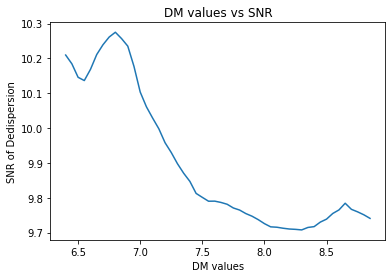

In [27]:
small_data = data_adjust[:,0,:]
data_base = data_adjust[:,0,:]
sens =0.05
DM_base =  6.4  
candidates = 50
fchan = obs.header['fch1']
width = obs.header['foff']
tsamp = obs.header['tsamp']
fchan = fchan+ width*small_data.shape[1]
snrs = DM_can(small_data, data_base, sens, DM_base, candidates, fchan, abs(width),tsamp)
plt.plot(snrs[:,0], snrs[:,1])
plt.title('DM values vs SNR')
plt.xlabel("DM values")
plt.ylabel("SNR of Dedispersion")

6.800000000000001


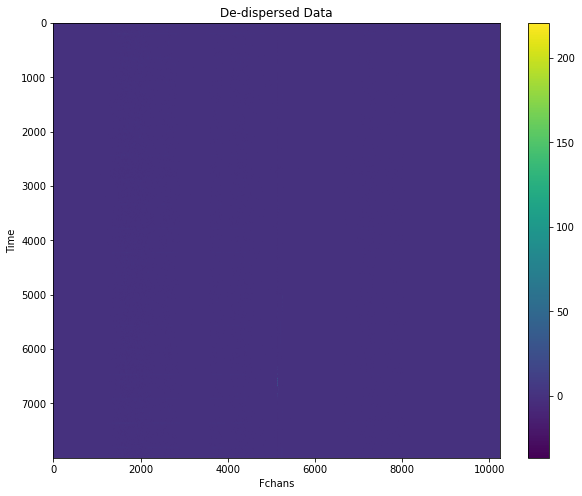

In [0]:
DM = snrs[np.argmax(snrs[:,1]),0]
print(DM)
fchan = fchan+ width*small_data.shape[1]
data_adjust[:,0,:] = de_disperse(data_adjust[:,0,:], DM, fchan,abs(width),tsamp)
fig = plt.figure(figsize=(10, 8))
plt.imshow(data_adjust[:,0,:], aspect='auto')
plt.title('De-dispersed Data')
plt.xlabel("Fchans")
plt.ylabel("Time")
plt.colorbar()
plt.show() 

# Detecting Pulses - Fourier Transforms and Folding

What we do next is we take the Fourier transform of the original signal and take the magnitude of the Fourier transform. A large magnitude indicates a potential period within that signal. Or a repeating signal. Note the magnitude takes the real part of the Fourier transform. 

If the magnitude of the Fourier transform is above a certain threshold we can consider it as a candidate for folding. We save the top candidates and fold the data based on these periods. 

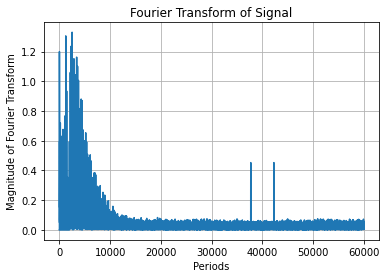

Signal To Noise Ratio for the Fourier Transform is: 3.6559125533569086
Most likely Candidates are: [180, 716, 895, 3, 537, 359, 1074, 1610, 1789, 1431, 358, 1253, 538, 1968, 2683]


In [0]:
#  Preforming the fourier transform.
%matplotlib inline
import scipy.fftpack
from scipy.fft import fft
N = 1000
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = abs(data_adjust[:,0,:].mean(axis=1))
yf = fft(y)

xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

# Magintude of the fourier transform
# Between 0.00035 and 3.5 seconds
mag = np.abs(yf[:60000])
candidates = top(mag, top=15)
plt.plot(2.0/N * mag[1:])
plt.grid()
plt.title('Fourier Transform of Signal')
plt.xlabel("Periods")
plt.ylabel("Magnitude of Fourier Transform")
plt.show()

print("Signal To Noise Ratio for the Fourier Transform is: "+str(SNR(mag)))
print("Most likely Candidates are: "+str(candidates))

# Folding Algorithm 

The idea of the folding algorithm is to see if the signal forms a consistent profile as you fold/integrate the values together. If the profile appears consistent/stable then you're looking at an accurate reading of the pulsar's period. It is used to confirm the implications drawn from the Fourier transform. This is typically called profiling the pulsar. When folding the pulses it forms a "fingerprint" of the pulsar. These folds are unique to the pulsar detected. 

$$s_j = \sum^{N/P-1}_{K=0} D_{j+kP} $$

We are suming over the regular intervals of period `P`. This is implemented below.

![alt text](https://github.com/PetchMa/Pulsar_Folding/blob/master/assets/can_3.gif?raw=true)

2.6899003919476705


Text(0, 0.5, 'Normalized Integrated Signal')

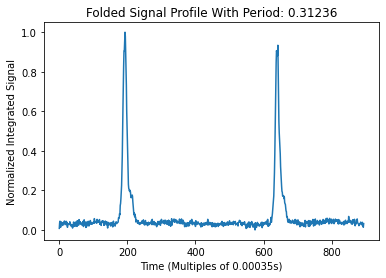

In [0]:
#  Lets take an example of such a period!
#  The  0th candidate is the top ranked candidate by the FFT
period = 895
fold = np.zeros((period, data.shape[2]))
multiples = int(data.data.shape[0]/period)
results = np.zeros((period))

for i in range(multiples-1):
  fold[:,:]=data_adjust[i*period:(i+1)*period,0,:]+ fold

results = fold.mean(axis=1)
results = results - results.min()
results = results / results.max()

print(SNR(results))

plt.plot(results)
plt.title('Folded Signal Profile With Period: '+str(round(period*0.000349,5)))
plt.xlabel("Time (Multiples of 0.00035s)")
plt.ylabel("Normalized Integrated Signal")

In [0]:
#  Lets take an example of such a period!
#  The  0th candidate is the top ranked candidate by the FFT
can_snr =[]
for k in range(len(candidates)):
  period = candidates[k]
  fold = np.zeros((period, data.shape[2]))
  multiples = int(data.data.shape[0]/period)
  results = np.zeros((period))

  for i in range(multiples-1):
    fold[:,:]=data[i*period:(i+1)*period,0,:]+ fold

  results = fold.mean(axis=1)
  results = results - results.min()
  results = results / results.max()
  can_snr.append(SNR(results))
  # print(SNR(results))

print("Max SNR of Fold Candidates: "+ str(max(can_snr)))

Max SNR of Fold Candidates: 2.657056217368029


The Signal To Noise of the Fold is: 2.657056217368029


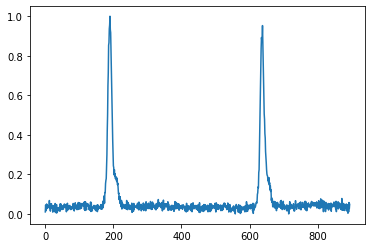

In [0]:
# Generates multiple images saved to create a GIF 
from scipy import stats 
data = data
period = candidates[0]
fold = np.zeros((period, data.shape[2]))
multiples = int(data.data.shape[0]/period)
results = np.zeros((period))

for i in range(multiples-1):
  fold[:,:]=data[i*period:(i+1)*period,0,:]+ fold
  results = fold.mean(axis=1)
  results = results - results.min()
  results = results / results.max()
  #  Generates multiple frames of the graph as it folds! 
  plt.plot(results)
  plt.title('Folded Signal Period '+str(period*0.000349)+" seconds| Fold Iteration: "+str(i))
  plt.xlabel("Time (Multiples of 0.00035s)")
  plt.ylabel("Normalized Integrated Signal")
  plt.savefig('/content/drive/My Drive/Deeplearning/Pulsars/output/candidates/CAN_3/multi_chan_'+str(period)+'_'+str(i)+'.png')
  plt.close()
  
results = fold.mean(axis=1)
results = results - results.min()
results = results / results.max()

print("The Signal To Noise of the Fold is: "+str(SNR(results)))
plt.plot(results)

# What Happens If The Data Doesn't Contain Pulses?

Below we will show to you that this algorithm detects repeated pulses and **excludes targets that do not include this feature**. We will do so by loading a target that isn't known to contain pulsars. `HIP65960` is a target that doesn't contain repeating signals.

Below we will repeat and apply the same algorithm but on a target that isn't a pulsar. We won't reiterate the explanations again. 

In [33]:
!wget http://blpd13.ssl.berkeley.edu/dl/GBT_58402_66282_HIP65960_time.h5

--2020-06-01 01:56:39--  http://blpd13.ssl.berkeley.edu/dl/GBT_58402_66282_HIP65960_time.h5
Resolving blpd13.ssl.berkeley.edu (blpd13.ssl.berkeley.edu)... 208.68.240.55
Connecting to blpd13.ssl.berkeley.edu (blpd13.ssl.berkeley.edu)|208.68.240.55|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1471544819 (1.4G) [application/octet-stream]
Saving to: ‘GBT_58402_66282_HIP65960_time.h5’

GBT_58402_66282_HIP 100%[===================>]   1.37G  15.8MB/s    in 87s     

2020-06-01 01:58:08 (16.1 MB/s) - ‘GBT_58402_66282_HIP65960_time.h5’ saved [1471544819/1471544819]



blimpy.io.base_reader WARNING  Selection size of 1.97 GB, exceeding our size limit 1.00 GB. Instance created, header loaded, but data not loaded, please try another (t,v) selection.

--- File Info ---
DIMENSION_LABELS : [b'frequency' b'feed_id' b'time']
        az_start :                              0.0
       data_type :                                1
            fch1 :                2720.80078125 MHz
            foff :                -0.3662109375 MHz
           ibeam :                                0
      machine_id :                               10
          nbeams :                                0
           nbits :                                8
          nchans :                             2464
            nifs :                                1
     rawdatafile :                                 
     source_name :                         HIP65960
         src_dej :                      54:55:17.63
         src_raj :                     13:31:26.674
    telescope_id :

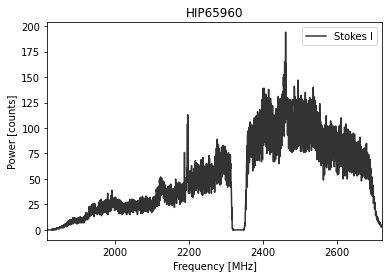

In [16]:
from blimpy import Waterfall
import pylab as plt
import numpy as np
import math
from scipy import stats, interpolate

%matplotlib inline


header = Waterfall('/content/GBT_58402_66282_HIP65960_time.h5',load_data=True)
header.info()

obs = Waterfall('/content/GBT_58402_66282_HIP65960_time.h5', 
               f_start=0,f_stop= 361408,max_load=5)
# Loads data into numpy array 
data = obs.data
coarse_channel_width = np.int(np.round(187.5/64/abs(obs.header['foff'])))
obs.plot_spectrum()

In [0]:
average_power = np.zeros((data.shape[2]))
shifted_power = np.zeros((int(data.shape[2]/8)))
x=[]
spl_order = 2
print("Fitting Spline")
data_adjust = np.zeros(data.shape)
average_power = data.mean(axis=0)
#  Note the value 8 is the COARSE CHANNEL WIDTH
#  We adjust each coarse channel to correct the bandpass artifacts
for i in range(0, data.shape[2], coarse_channel_width):
    average_channel = average_power[0,i:i+coarse_channel_width]
    x = np.arange(0,coarse_channel_width,1)
    knots = np.arange(0, coarse_channel_width, coarse_channel_width//spl_order+1)

    tck = interpolate.splrep(x, average_channel, s=knots[1:])
    xnew = np.arange(0, coarse_channel_width,1)
    ynew = interpolate.splev(xnew, tck, der=0)
    data_adjust[:,0,i:i+coarse_channel_width]  = data[:,0,i:i+coarse_channel_width] - ynew


Fitting Spline


Candidate 0	 SNR: 0.0332	 Largest Time Delay: 0.000472 seconds	 DM val:6.4pc/cm^3
Candidate 1	 SNR: 0.0329	 Largest Time Delay: 0.000476 seconds	 DM val:6.45pc/cm^3
Candidate 2	 SNR: 0.0324	 Largest Time Delay: 0.000479 seconds	 DM val:6.5pc/cm^3
Candidate 3	 SNR: 0.0324	 Largest Time Delay: 0.000483 seconds	 DM val:6.550000000000001pc/cm^3
Candidate 4	 SNR: 0.0334	 Largest Time Delay: 0.000487 seconds	 DM val:6.6000000000000005pc/cm^3
Candidate 5	 SNR: 0.0341	 Largest Time Delay: 0.00049 seconds	 DM val:6.65pc/cm^3
Candidate 6	 SNR: 0.0345	 Largest Time Delay: 0.000494 seconds	 DM val:6.7pc/cm^3
Candidate 7	 SNR: 0.0351	 Largest Time Delay: 0.000498 seconds	 DM val:6.75pc/cm^3
Candidate 8	 SNR: 0.0352	 Largest Time Delay: 0.000501 seconds	 DM val:6.800000000000001pc/cm^3
Candidate 9	 SNR: 0.0351	 Largest Time Delay: 0.000505 seconds	 DM val:6.8500000000000005pc/cm^3
Candidate 10	 SNR: 0.0349	 Largest Time Delay: 0.000509 seconds	 DM val:6.9pc/cm^3
Candidate 11	 SNR: 0.0345	 Largest Ti

Text(0, 0.5, 'SNR of Dedispersion')

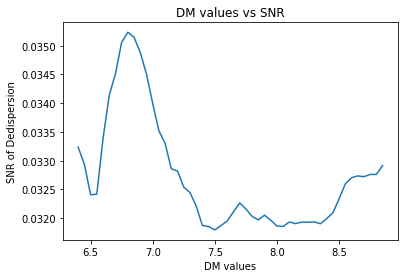

In [29]:
from copy import deepcopy
small_data = data[:,0,:]
data_base = data[:,0,:]
sens =0.05
DM_base = 6.4  
candidates = 50
fchan = obs.header['fch1']
width = obs.header['foff']
tsamp = obs.header['tsamp']
# fchan = fchan+ width*small_data.shape[1]
fchan = 7501.28173828125
snrs = DM_can(small_data, data_base, sens, DM_base, candidates, fchan, abs(width),tsamp)
plt.plot(snrs[:,0], snrs[:,1])
plt.title('DM values vs SNR')
plt.xlabel("DM values")
plt.ylabel("SNR of Dedispersion")

In [30]:
DM = snrs[np.argmax(snrs[:,1]),0]
print(DM)
fchan = fchan+ width*small_data.shape[1]
data_adjust[:,0,:] = de_disperse(data_adjust[:,0,:], DM, fchan,abs(width),tsamp)

6.800000000000001


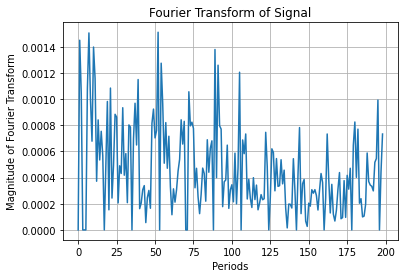

Signal To Noise Ratio for the Fourier Transform is: 1.2053418739341748
Most likely Candidates are: [19, 37, 6, 144, 126, 108, 55, 5, 162, 73, 7, 90, 180, 72, 198]


In [31]:
#  Preforming the fourier transform.
%matplotlib inline
import scipy.fftpack
from scipy.fft import fft
N = 60000
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = data[:,0,:].mean(axis=1)
yf = fft(y)

xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

# Magintude of the fourier transform
# Between 0.00035 and 3.5 seconds
# We set this to a limit of 200 because 
# The total tchan is only 279
mag = np.abs(yf[:200])
candidates = top(mag, top=15)
plt.plot(2.0/N * mag[1:])
plt.grid()
plt.title('Fourier Transform of Signal')
plt.xlabel("Periods")
plt.ylabel("Magnitude of Fourier Transform")
plt.show()

print("Signal To Noise Ratio for the Fourier Transform is: "+str(SNR(mag)))
print("Most likely Candidates are: "+str(candidates))


# NOTICE
Notice how the signal to noise ratio is a lot smaller, It's smaller by 2 orders of magnitude (100x) than the original pulsar fold. Typically with a SNR of 1, it isn't considered a signal of interest as it's most likely just noise.


In [0]:
#  Lets take an example of such a period!
#  The  0th candidate is the top ranked candidate by the FFT
can_snr =[]
for k in range(len(candidates)):
  period = candidates[k]
  fold = np.zeros((period, data.shape[2]))
  multiples = int(data.data.shape[0]/period)
  results = np.zeros((period))

  for i in range(multiples-1):
    fold[:,:]=data[i*period:(i+1)*period,0,:]+ fold

  results = fold.mean(axis=1)
  results = results - results.min()
  results = results / results.max()
  can_snr.append(SNR(results))
  

print("Max SNR of Fold Candidates: "+ str(max(can_snr)))

Max SNR of Fold Candidates: 0.9867689288276708


# Result

It is fair to conclude that given this observation of `HIP65960` this target is most likely not a pulsar as the SNR of the FFT and the folding is not high enough to suggest otherwise. 

# Any Questions?

Feel free to reach out with any questions about this notebook: peterxiangyuanma@gmail.com
